Panama City - MSE: 0.0491, R² Score: 0.0539, Training Time: 0.0066s, Prediction Time: 0.0017s
Gainesville - MSE: 0.0688, R² Score: 0.0460, Training Time: 0.0053s, Prediction Time: 0.0011s
Miami - MSE: 0.0603, R² Score: 0.1130, Training Time: 0.0065s, Prediction Time: 0.0013s
Orlando - MSE: 0.0476, R² Score: 0.0342, Training Time: 0.0076s, Prediction Time: 0.0014s
Tampa - MSE: 0.0495, R² Score: 0.0679, Training Time: 0.0084s, Prediction Time: 0.0017s


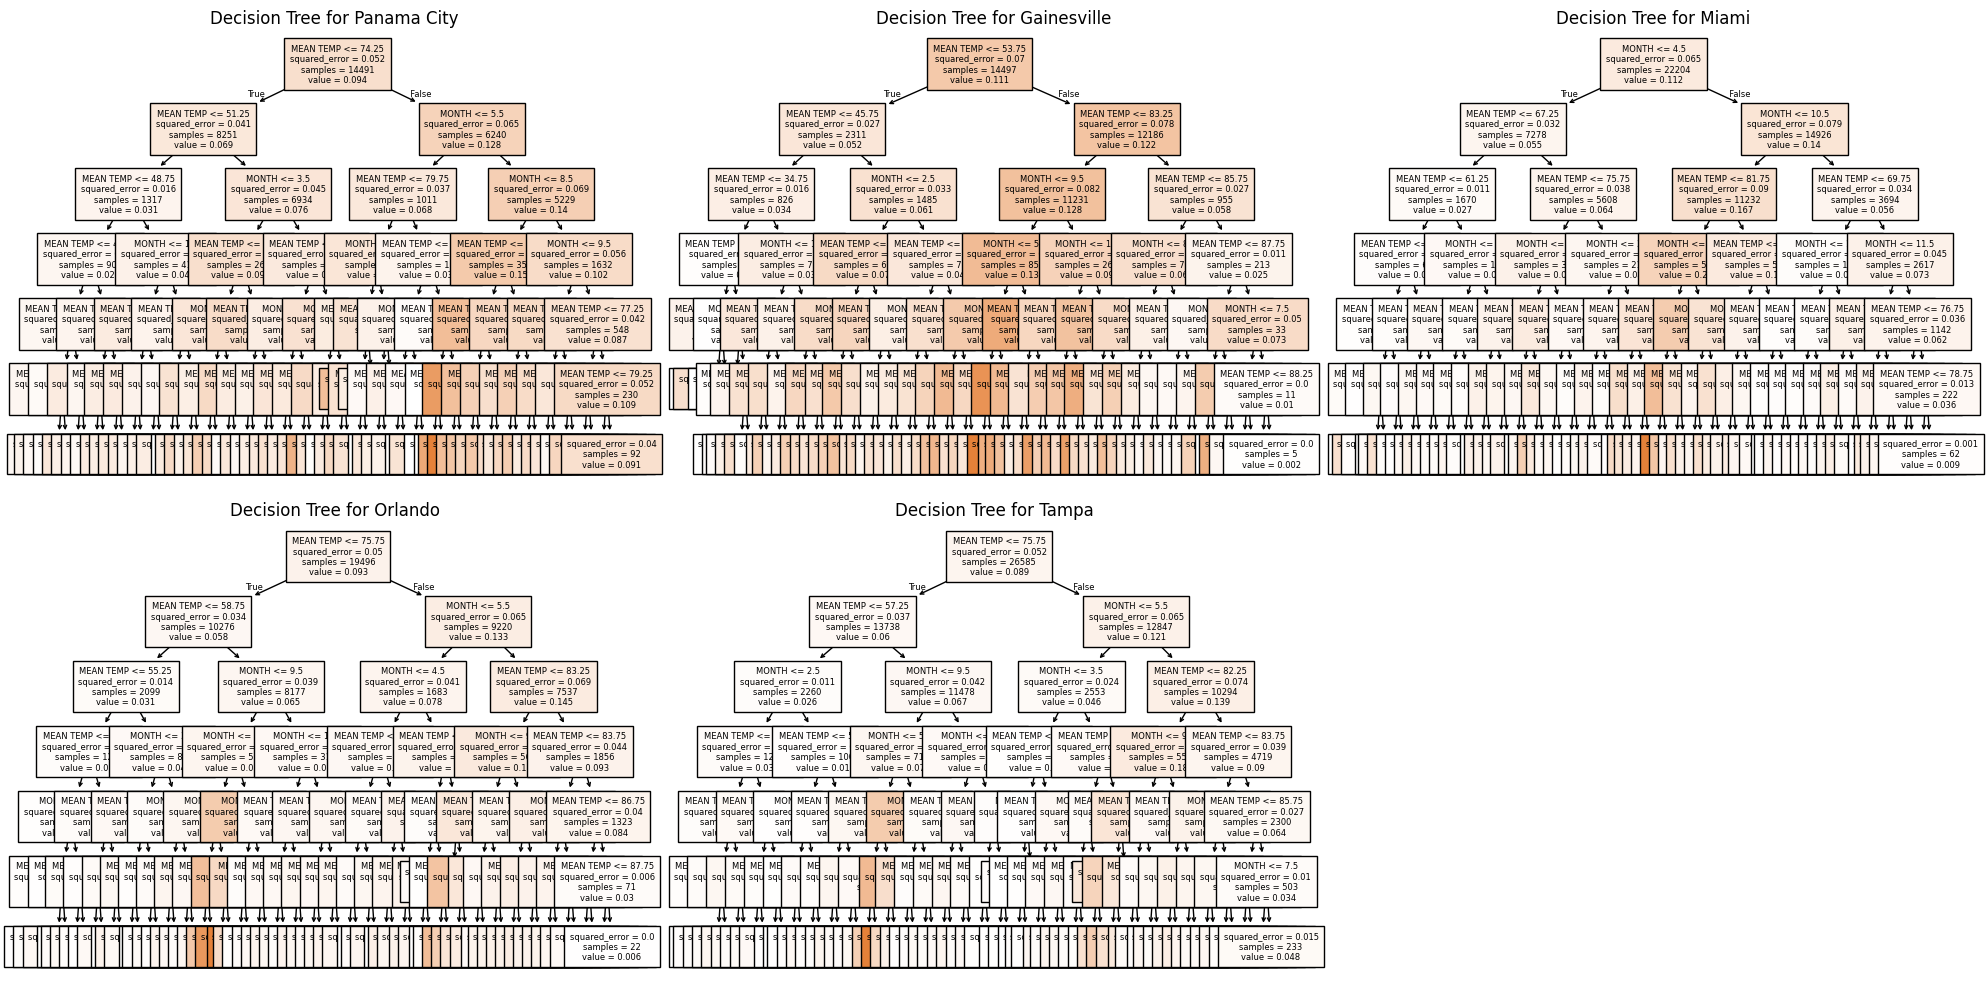

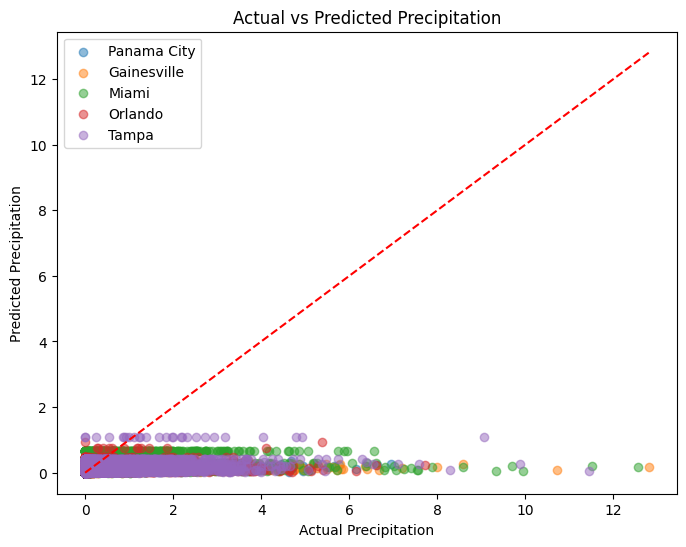

In [6]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score

files = {
    "Panama City": "data/PanamaCityWeather.csv",
    "Gainesville": "data/GainsvilleWeather.csv",
    "Miami": "data/MiamiWeather.csv",
    "Orlando": "data/OrlandoWeather.csv",
    "Tampa": "data/TampaWeather.csv"
}
dfs = []
for city, file_path in files.items():
    df = pd.read_csv(file_path)
    df['City'] = city
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
#clean up white spaces
combined_df.columns = combined_df.columns.str.strip()
# change -99 to nan to rmeove later
combined_df.replace([-99.9, -99.99], np.nan, inplace=True)

combined_df['Date'] = pd.to_datetime(
    combined_df[['YEAR', 'MONTH', 'DAY']].rename(columns={
        'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'
    }),
    errors='coerce'
)
# remove any of the -99
combined_df.dropna(subset=['Date'], inplace=True)
#remove any of the -99
combined_df_clean = combined_df.dropna(subset=["PRECIPITATION", "MAX TEMP", "MIN TEMP", "MEAN TEMP"])

combined_df_clean.reset_index(drop=True, inplace=True)

cities = combined_df_clean["City"].unique()
city_models = {}
plt.figure(figsize=(20, 10))

for i, city in enumerate(cities, 1):
    city_data = combined_df_clean[combined_df_clean['City'] == city]

    # Selecting relevant features and target
    X = city_data[['MEAN TEMP', 'MONTH']]
    y = np.log1p(city_data['PRECIPITATION'])

    # Split into training and testing sets (80%, 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    
    # Train Decision Tree Regressor
    model = DecisionTreeRegressor(max_depth=6, min_samples_split=5, min_samples_leaf=2, random_state=42)
    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    city_models[city] = model

    start_time = time.time()
    y_pred = np.expm1(model.predict(X_test))
    prediction_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{city} - MSE: {mse:.4f}, R² Score: {r2:.4f}, Training Time: {training_time:.4f}s, Prediction Time: {prediction_time:.4f}s")

    # Plot decision tree for each city
    plt.subplot(2, len(cities)//2 + 1, i)
    plot_tree(model, feature_names=['MEAN TEMP', 'MONTH'], filled=True, fontsize=6)
    plt.title(f'Decision Tree for {city}')

plt.tight_layout()  
plt.show()

# Scatter plot to visualize actual vs predicted precipitation
plt.figure(figsize=(8, 6))
for city, model in city_models.items():
    city_data = combined_df_clean[combined_df_clean['City'] == city]
    X_city = city_data[['MEAN TEMP', 'MONTH']]
    y_city_actual = city_data['PRECIPITATION']
    y_city_pred = model.predict(X_city)

    plt.scatter(y_city_actual, y_city_pred, label=city, alpha=0.5)

plt.plot([min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         [min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         color='red', linestyle='--')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend()
plt.title('Actual vs Predicted Precipitation')
plt.show()


Panama City - MSE: 0.1441, R² Score: 0.1382, Training Time: 0.2236s, Prediction Time: 0.0278s
Gainesville - MSE: 0.2266, R² Score: 0.1449, Training Time: 0.2118s, Prediction Time: 0.0425s
Miami - MSE: 0.2515, R² Score: 0.1410, Training Time: 0.2476s, Prediction Time: 0.0389s
Orlando - MSE: 0.1401, R² Score: 0.0855, Training Time: 0.3147s, Prediction Time: 0.0394s
Tampa - MSE: 0.1321, R² Score: 0.1901, Training Time: 0.4678s, Prediction Time: 0.0384s


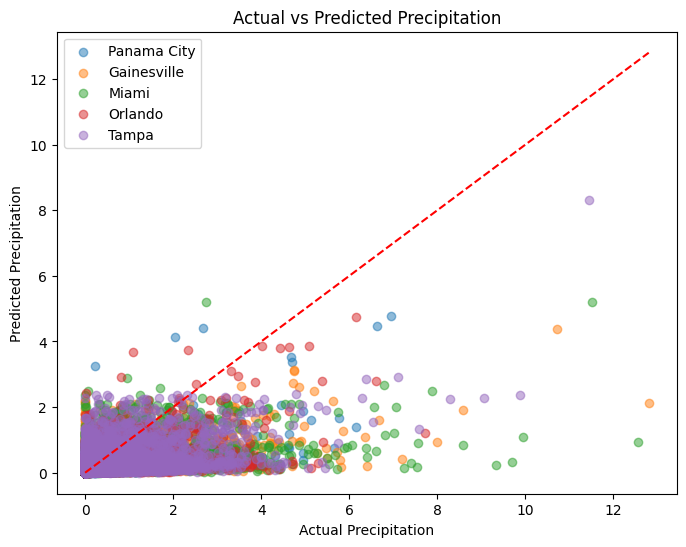

In [7]:
from sklearn.ensemble import RandomForestRegressor

for i, city in enumerate(cities, 1):
    city_data = combined_df_clean[combined_df_clean['City'] == city]

    # Selecting relevant features and target
    X = city_data[['MEAN TEMP','MAX TEMP', 'MIN TEMP', 'MONTH']]
    y = city_data['PRECIPITATION']

    # Split into training and testing sets (80%, 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    
    # Train Decision Tree Regressor
    model = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    training_time = time.time() - start_time

    city_models[city] = model

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{city} - MSE: {mse:.4f}, R² Score: {r2:.4f}, Training Time: {training_time:.4f}s, Prediction Time: {prediction_time:.4f}s")

    # Plot decision tree for each city
    #plt.subplot(2, len(cities)//2 + 1, i)
    #plot_tree(model, feature_names=['MEAN TEMP', 'MONTH'], filled=True, fontsize=6)
    #plt.title(f'Decision Tree for {city}')

#plt.tight_layout()  
#plt.show()

# Scatter plot to visualize actual vs predicted precipitation
plt.figure(figsize=(8, 6))
for city, model in city_models.items():
    city_data = combined_df_clean[combined_df_clean['City'] == city]
    X_city = city_data[['MEAN TEMP', 'MAX TEMP', 'MIN TEMP', 'MONTH']]
    y_city_actual = city_data['PRECIPITATION']
    y_city_pred = model.predict(X_city)

    plt.scatter(y_city_actual, y_city_pred, label=city, alpha=0.5)

plt.plot([min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         [min(combined_df_clean['PRECIPITATION']), max(combined_df_clean['PRECIPITATION'])], 
         color='red', linestyle='--')
plt.xlabel('Actual Precipitation')
plt.ylabel('Predicted Precipitation')
plt.legend()
plt.title('Actual vs Predicted Precipitation')
plt.show()